<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020

## Proyecto lenguaje de señas

### Integrantes:
* Deisy Tatiana Macias
* Dayana Romero
* Juan José Villegas
* Juan Sebastián Méndez

# 0. Toma de datos

Para la toma de datos, se hizo un programa en nodeJS que utiliza el modelo "handpose" de media pipe con tensor flow. Este programa nos permite, por medio de la cámara del computador, tomar las coordenadas de todos los _landmarks_ de la mano (más detalles en el diccionario), siendo mostradas en un cuadro de texto que luego era copiado y pegado a un archivo de excel. El código fuente está en el siguiente repositorio: https://github.com/jjr2040/ml-sign-language.

<img src="./Images/TomaDatos.png" >

Se tomaron los datos correspondientes a las coordenadas de las señas del cero al diez, con muestras de 5 segundos cada una y con una certeza de mano (el programa está seguro que el objeto en frente es una mano) del 99%. Esto generaba aproximadamente de 20 a 40 datos por cada muestra. Igualmente se tomaron las muestras en diferentes condiciones de luz y con manos de diferentes tamaños (hombres, mujeres, y niños).

# 1. Importando las librerias requeridas

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

# 2. Perfilamiento y entendimiento de los datos

<img src="./Images/Landmarks.png" >

Los datos tal como vienen del programa nos arroja tres coordenadas por cada uno de los landmarks en donde la coordenada x=0 y y=0 son la esquina abajo izquierda de la imágen. El tamaño de la imágen es fija a 640x500 pixeles. Así nuestro rango para la coordenada x y y es de 0 <= x <= 640 y 0 <= y <= 500. La coordenada cero es relativa a un punto intermedio en la pantalla (que se vean todos los puntos centrados en pantalla). A medida que la mano se acerca a la cámara obtenemos valores positivos, y si se aleja nos arroja valores negativos.

In [2]:
# Importando los datos
diccionario = pd.read_csv('./data/diccionario.csv', encoding = "UTF-8")
data = pd.read_csv('./data/datos.csv', encoding = "UTF-8")

In [3]:
diccionario

,Columna,Descripción
0,x0,Coordenada X LM 0 Correspondiente a la muñeca
1,y0,Coordenada Y LM 0 Correspondiente a la muñeca
2,z0,Coordenada Z LM 0 Correspondiente a la muñeca
3,x1,Coordenada X LM 1 Correspondiente al dedo pulgar
4,y1,Coordenada Y LM 1 Correspondiente al dedo pulgar
...,...,...
59,z19,Coordenada Z LM 19 Correspondiente a la tercer...
60,x20,Coordenada X LM 20 Correspondiente a la punta ...
61,y20,Coordenada Y LM 20 Correspondiente a la punta ...
62,z20,Coordenada Z LM 20 Correspondiente a la punta ...


In [4]:
data.head()

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,x18,y18,z18,x19,y19,z19,x20,y20,z20,clase
0,284.92805,350.67788,-0.00093,322.79277,315.33405,8.39052,347.40954,277.24308,11.12329,372.08923,...,286.79234,172.75314,-6.02986,295.90823,144.13841,-4.17843,305.38755,114.55426,-2.41008,0
1,278.28085,345.40205,-0.00130,318.74006,314.35025,6.34735,346.35429,277.35317,8.47528,371.35733,...,291.32571,172.43149,-7.07840,299.57190,145.29706,-6.46456,307.54150,116.75922,-6.23263,0
2,276.40025,344.67422,-0.00131,317.00817,313.70587,5.75395,344.34662,276.55692,7.94423,366.93927,...,289.30880,173.07098,-7.00137,296.22140,146.44763,-6.53205,303.59922,118.51561,-6.35039,0
3,274.34967,343.92245,-0.00131,317.74627,312.19434,7.38592,345.21930,274.20845,10.34781,368.13793,...,290.49569,170.87830,-5.92087,299.04903,143.51583,-5.19691,307.87086,115.32076,-4.96793,0
4,273.91013,343.22628,-0.00133,320.29775,310.32568,7.56058,349.07755,272.35242,10.71873,373.16762,...,291.84546,169.00737,-5.37861,299.95371,141.54401,-4.62802,307.74208,113.48242,-4.36697,0


In [5]:
#profile = ProfileReport(data)
#profile.to_file("profile_report.html")

Se sacan los histogramas de las variables para ver cómo están distribuídas y encontrar posibilidades de mejora, tranformación y tratamientos de los datos 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127bd3810>,
      dtype=object)

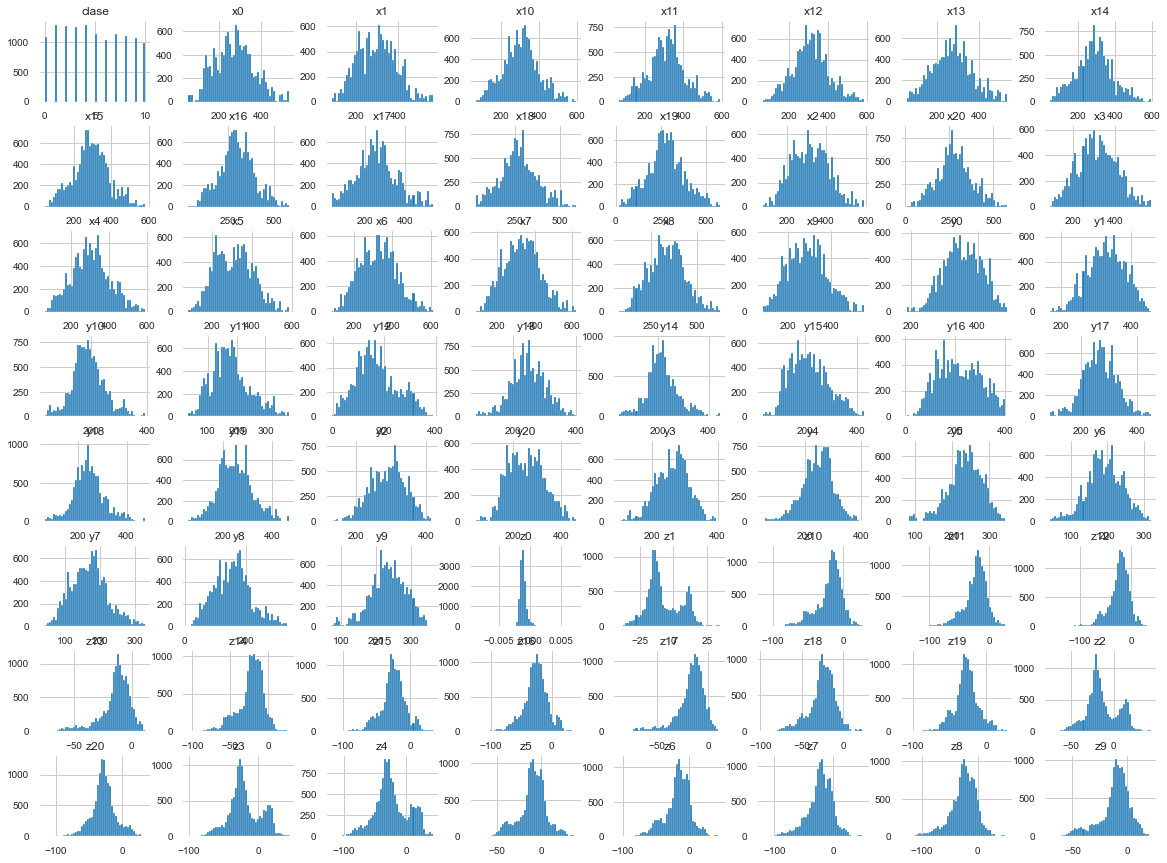

In [6]:
data.hist(bins=50, figsize=(20, 15))

Podemos ver que no hay una variable que valga la pena tratar y, para esta primera iteración, se van a usar tal como estás.

# 3. Limpieza y preparación de datos

Se considera que no se debe eliminar ninguna columna, porque los datos fueron tomados de una imagen y estos representan coordenadas que son necesarias en su completitud para determinar el número. Debido a esto, no consideramos aplicable un estudio de correlación.

La estandarización no se realiza, porque los datos son tomados de un plano cartesiano de tres dimensiones por lo que se maneja la misma escala en todos los datos que se tomaron. Esto quiere decir, que por la forma en que se recolectaron los datos no se requiere aplicar algún tratamiento a los datos.

Aún así, y a modo de anticiparnos a los posibles algoritmos, y dado que las coordenadas X y Y están dadas en número de pixeles, una posible opción de tratamiento sería la normalización de las coordenadas para que no dependan del tamaño de la imagen.

In [7]:
X, Y = data.drop(['clase'], axis=1), data['clase']

In [11]:
xy_preprocessor = make_pipeline(
    MinMaxScaler(feature_range=(0,1))
)

z_preprocessor = make_pipeline(
    MinMaxScaler(feature_range=(-1,1))
)

x_columns = ('x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20')
y_columns = ('y0','y1','y2','y3','y4','y5','y6','y7','y8','y9','y10','y11','y12','y13','y14','y15','y16','y17','y18','y19','y20')
z_columns = ('z0','z1','z2','z3','z4','z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20')

preprocessor = make_column_transformer(
    (xy_preprocessor, x_columns),
    (xy_preprocessor, y_columns),
    (z_preprocessor, z_columns),
    remainder='passthrough'
)

In [13]:
X_ready = preprocessor.fit_transform(X)
X_ready

array([[ 0.482039  ,  0.49410185,  0.52522703, ...,  0.49236949,
         0.51663435,  0.50691356],
       [ 0.46809237,  0.48574191,  0.52314331, ...,  0.47510409,
         0.48325858,  0.45628311],
       [ 0.46414664,  0.48216936,  0.5191789 , ...,  0.47637248,
         0.48227328,  0.45472336],
       ...,
       [ 0.26082421,  0.27552138,  0.32476207, ..., -0.40263907,
        -0.04247391,  0.04034894],
       [ 0.26197117,  0.28202768,  0.32736341, ..., -0.39158663,
        -0.03030076,  0.04059152],
       [ 0.26528878,  0.28034523,  0.32458367, ..., -0.40212098,
        -0.03701094,  0.04380005]])

# 4. Modelamiento

# 5. Predicción

# 6. Validación